In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_wine, load_digits, load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report)

from dopnet_loader import DopNetLoader
from qga import QGA

In [2]:
data = load_wine()
X = data.data
y = data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42)

=== BASELINE SVM (default hyperparameters) ===
Accuracy: 0.9814814814814815

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.95      1.00      0.98        21
           2       1.00      0.93      0.96        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



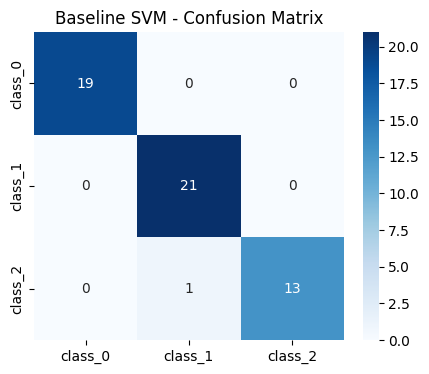

Cross-validation accuracy: 0.9676666666666666


In [30]:
print('=== BASELINE SVM (default hyperparameters) ===')

baseline = SVC(kernel='rbf')
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='Blues',
           xticklabels=data.target_names,
           yticklabels=data.target_names)
plt.title('Baseline SVM - Confusion Matrix')
plt.show()

baseline_cv = cross_val_score(baseline, X_train, y_train, cv=5).mean()
print('Cross-validation accuracy:', baseline_cv)

In [31]:
print('=== RUNNING QGA ===')

qga = QGA(
    X_train,
    y_train,
    generations=50,
    population_size=20,
    genome_length=24,
    verbose_logging=True
)
qga.run()

best_gen = qga.history[-1]
print('\nLast generation:', best_gen)

=== RUNNING QGA ===
QUANTUM GENETIC ALGORITHM

[Gen 0] Chromosome 1: C=2.22085, gamma=1.01988, fitness=55.70
[Gen 0] Chromosome 2: C=1.05368, gamma=1.89307, fitness=40.33
[Gen 0] Chromosome 3: C=15.66289, gamma=7.40206, fitness=40.33
[Gen 0] Chromosome 4: C=0.00470, gamma=0.00015, fitness=40.33
[Gen 0] Chromosome 5: C=32.90153, gamma=6.97769, fitness=40.33
[Gen 0] Chromosome 6: C=0.00240, gamma=0.00105, fitness=40.33
[Gen 0] Chromosome 7: C=0.37025, gamma=0.00309, fitness=62.13
[Gen 0] Chromosome 8: C=2.42446, gamma=0.06708, fitness=97.57
[Gen 0] Chromosome 9: C=10.51909, gamma=7.74264, fitness=40.33
[Gen 0] Chromosome 10: C=423.03240, gamma=0.00011, fitness=96.80
[Gen 0] Chromosome 11: C=0.02014, gamma=0.00021, fitness=40.33
[Gen 0] Chromosome 12: C=2.42446, gamma=0.00111, fitness=96.80
[Gen 0] Chromosome 13: C=17.44851, gamma=0.00283, fitness=98.40
[Gen 0] Chromosome 14: C=3.44347, gamma=0.00424, fitness=97.60
[Gen 0] Chromosome 15: C=0.00153, gamma=0.20713, fitness=40.33
[Gen 0] Chr

In [32]:
best_idx = best_gen['best_index']

effective_bits = qga.genome_length - 1
half = effective_bits // 2
C_bits = qga.chromosome[best_idx, 1:1+half]
gamma_bits = qga.chromosome[best_idx, 1+half:1+effective_bits]

best_C = qga.decode_param(C_bits, -3, 3)
best_gamma = qga.decode_param(gamma_bits, -4, 1)
print("Best C:", best_C)
print("Best gamma:", best_gamma)

Best C: 186.9798778781704
Best gamma: 0.002630415893876958


=== SVM TRAINED WITH QGA PARAMETERS ===
Accuracy: 0.9814814814814815

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.95      0.98        21
           2       0.93      1.00      0.97        14

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



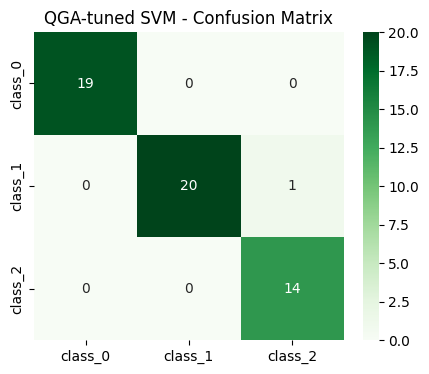

Cross-validation accuracy: 0.984


In [33]:
print("=== SVM TRAINED WITH QGA PARAMETERS ===")

svm_qga = SVC(kernel='rbf', C=best_C, gamma=best_gamma)
svm_qga.fit(X_train, y_train)

y_pred_qga = svm_qga.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_qga))
print("\nClassification Report:\n", classification_report(y_test, y_pred_qga))

cm_qga = confusion_matrix(y_test, y_pred_qga)
plt.figure(figsize=(5,4))
sns.heatmap(cm_qga, annot=True, cmap='Greens',
            xticklabels=data.target_names,
            yticklabels=data.target_names)
plt.title('QGA-tuned SVM - Confusion Matrix')
plt.show()

cv_qga = cross_val_score(svm_qga, X_train, y_train, cv=5).mean()
print("Cross-validation accuracy:", cv_qga)